 ## Step 1: Import Libraries

In [21]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 2: Load Dataset

In [22]:
url = "https://raw.githubusercontent.com/thealihassanatif/email-spam-classification/main/spam.csv"
df = pd.read_csv(url, encoding='latin-1')
df.columns = ['label', 'message']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})



## Step 3: Data Cleaning and Preprocessing

In [23]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

df['cleaned_message'] = df['message'].apply(preprocess_text)


## Step 4: Vectorization
Choose either Bag of Words (CountVectorizer) or TF-IDF.

In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_message'])

y = df['label']


## Step 5: Train-Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Step 6: Model Building
 Try all 3 models:

In [26]:
# Multinomial Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

# Logistic Regression
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Support Vector Machine
model_svm = SVC()
model_svm.fit(X_train, y_train)


SVC()

## Label Distribution (Spam vs Ham)

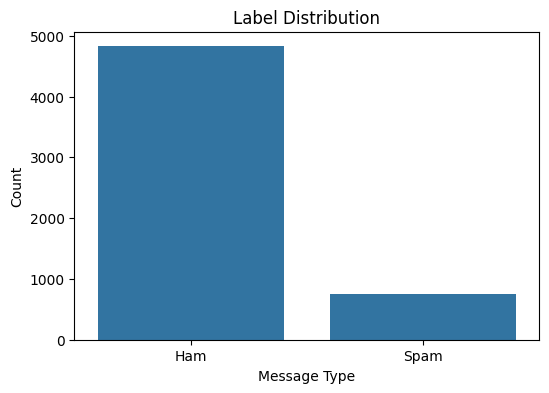

In [27]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.title('Label Distribution')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()


## Message Length Distribution

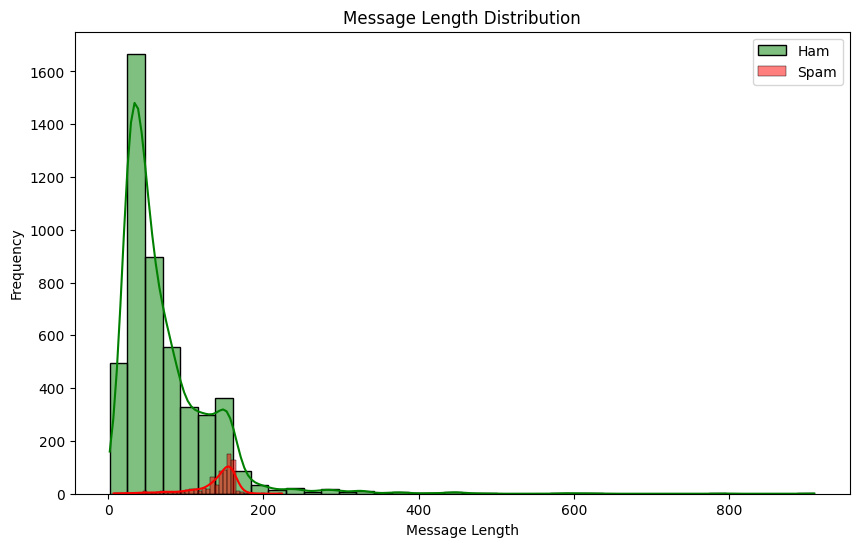

In [28]:
df['message_length'] = df['message'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(df[df['label'] == 0]['message_length'], bins=40, label='Ham', color='green', kde=True)
sns.histplot(df[df['label'] == 1]['message_length'], bins=40, label='Spam', color='red', kde=True)
plt.legend()
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()


## WordClouds for Spam and Ham

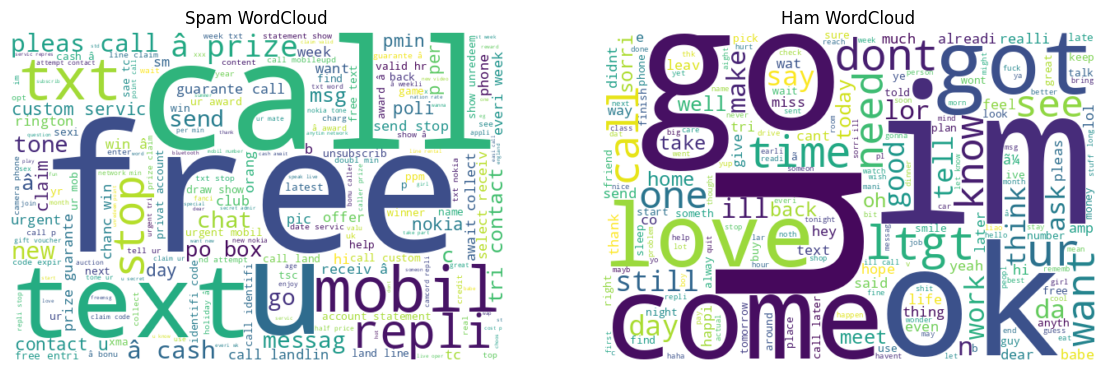

In [29]:
spam_words = ' '.join(df[df['label'] == 1]['cleaned_message'])
ham_words = ' '.join(df[df['label'] == 0]['cleaned_message'])

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
wordcloud_spam = WordCloud(width=600, height=400, background_color='white').generate(spam_words)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Spam WordCloud')

plt.subplot(1, 2, 2)
wordcloud_ham = WordCloud(width=600, height=400, background_color='white').generate(ham_words)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title('Ham WordCloud')

plt.show()


## Most Common Words (Bar Plot)

/tmp/ipython-input-2531250061.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[w[1] for w in common_words], y=[w[0] for w in common_words], palette='viridis')


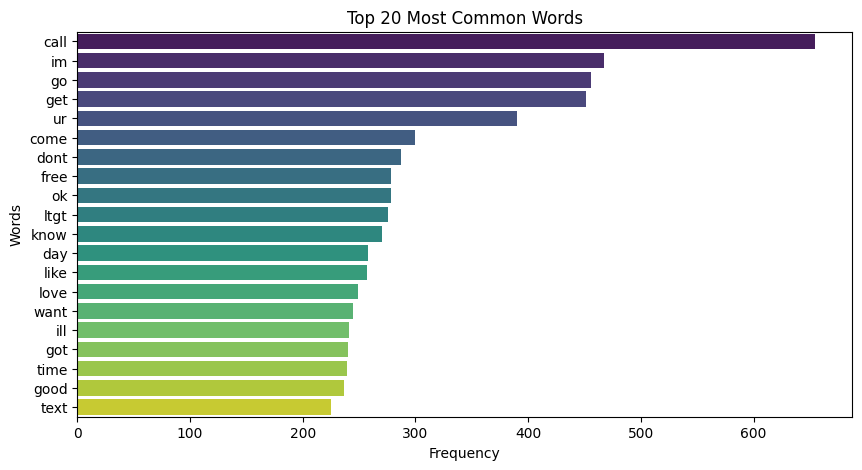

In [30]:
from collections import Counter

cv = CountVectorizer()
X_cv = cv.fit_transform(df['cleaned_message'])

word_freq = np.sum(X_cv.toarray(), axis=0)
words = cv.get_feature_names_out()
word_counts = dict(zip(words, word_freq))

common_words = Counter(word_counts).most_common(20)

plt.figure(figsize=(10,5))
sns.barplot(x=[w[1] for w in common_words], y=[w[0] for w in common_words], palette='viridis')
plt.title("Top 20 Most Common Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


## Confusion Matrix Heatmaps

--- Multinomial Naive Bayes ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



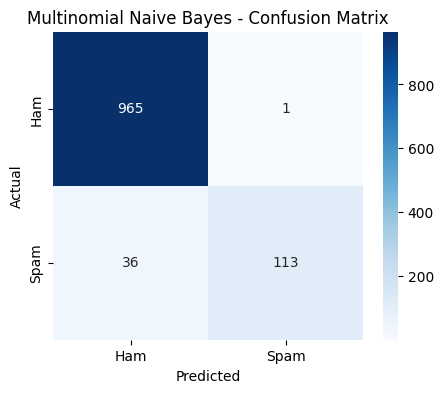

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       966
           1       0.99      0.69      0.81       149

    accuracy                           0.96      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.96      0.95      1115



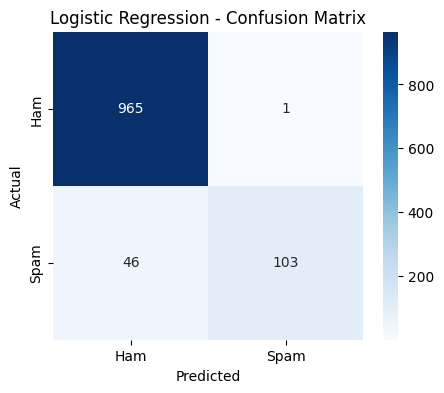

--- Support Vector Machine ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



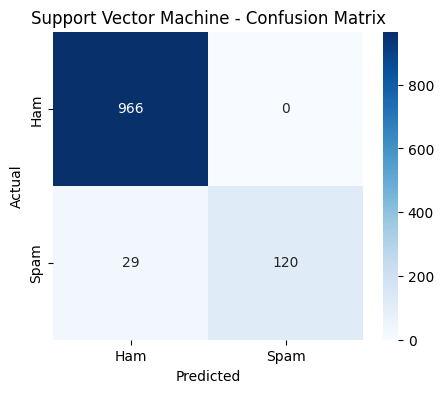

In [31]:
def evaluate_model(model, name):
    y_pred = model.predict(X_test)

    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

evaluate_model(model_nb, "Multinomial Naive Bayes")
evaluate_model(model_lr, "Logistic Regression")
evaluate_model(model_svm, "Support Vector Machine")



## Visual Feature Importance (Logistic Regression)

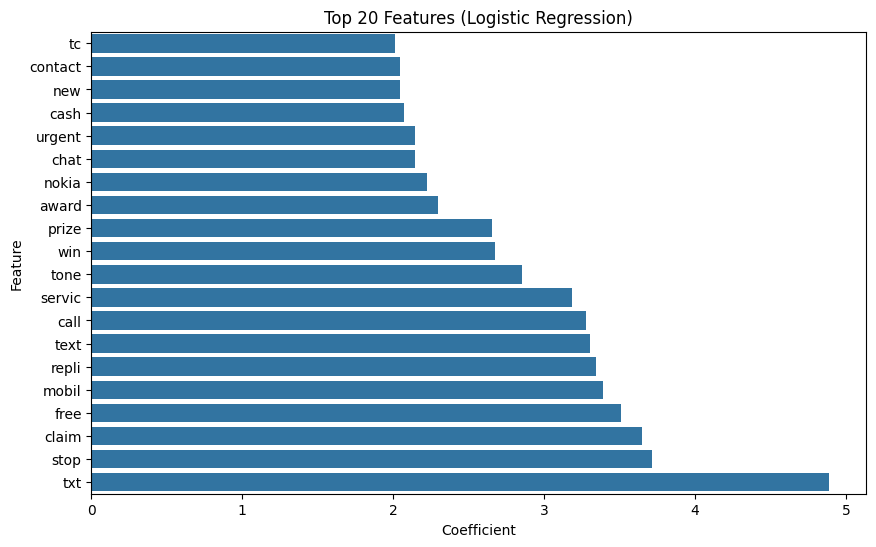

In [32]:
feature_names = vectorizer.get_feature_names_out()
coefficients = model_lr.coef_.flatten()
top_features = np.argsort(coefficients)[-20:]

plt.figure(figsize=(10,6))
sns.barplot(x=coefficients[top_features], y=feature_names[top_features])
plt.title("Top 20 Features (Logistic Regression)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()
